**1-Install required libraries**

ensures required libraries are present (YOLOv8, OpenCV, plotting tools)

In [1]:
!pip install -q ultralytics opencv-python-headless matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.2 MB/s eta 0:00:00


**2-Imports**

importing libraries

In [2]:
from ultralytics import YOLO
import os, zipfile, shutil, time
import cv2
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files
from tqdm import tqdm

def show_img(path, figsize=(6,6)):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize); plt.axis('off'); plt.imshow(img)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


**3-Upload dataset**

uploading my ZIP dataset and extract it

In [5]:
print("upload PlantVillage ZIP.")
uploaded = files.upload()

# Extract upload(s) to /content/dataset
for fn in uploaded.keys():
    if fn.endswith('.zip'):
        with zipfile.ZipFile(fn, 'r') as z:
            z.extractall('/content/dataset')
        print("Extracted to /content/dataset")
    else:
        print("Uploaded file (not zip):", fn)

# show top-level contents
print("\nTop-level folders under /content/dataset:")
!ls -la /content/dataset || true


upload PlantVillage ZIP.


Saving plantvillage_tomato.zip to plantvillage_tomato.zip
Extracted to /content/dataset

Top-level folders under /content/dataset:
total 12
drwxr-xr-x 3 root root 4096 Dec  9 02:53 .
drwxr-xr-x 1 root root 4096 Dec  9 02:53 ..
drwxr-xr-x 5 root root 4096 Dec  9 02:53 plantvillage_tomato


**4-Find dataset root & sample images**



In [6]:
candidates = []
for root, dirs, files_ in os.walk('/content/dataset'):
    names = set(dirs)
    if any('Tomato___Early_blight' in d for d in dirs) or any('Tomato___healthy' in d for d in dirs):
        candidates.append(root)
print("Detected candidate dataset roots:", candidates)
data_root = candidates[0] if candidates else '/content/dataset'
print("Using data_root =", data_root)


Detected candidate dataset roots: ['/content/dataset/plantvillage_tomato']
Using data_root = /content/dataset/plantvillage_tomato


**sample image from each class**

Early_blight: 55 images (example: ['/content/dataset/plantvillage_tomato/Tomato___Early_blight/0012b9d2-2130-4a06-a834-b1f3af34f57e___RS_Erly.B 8389.jpeg', '/content/dataset/plantvillage_tomato/Tomato___Early_blight/004cbe60-8ff9-4965-92df-e86694d5e9ba___RS_Erly.B 8253.jpeg', '/content/dataset/plantvillage_tomato/Tomato___Early_blight/03b4571c-b1eb-4e2a-b372-307046913f50___RS_Erly.B 7548.jpeg'])
Late_blight: 59 images (example: ['/content/dataset/plantvillage_tomato/Tomato___Late_blight/0003faa8-4b27-4c65-bf42-6d9e352ca1a5___RS_Late.B 4946.jpeg', '/content/dataset/plantvillage_tomato/Tomato___Late_blight/00355ec2-f12c-4015-b8f9-94354f69ce22___RS_Late.B 5311.jpeg', '/content/dataset/plantvillage_tomato/Tomato___Late_blight/005a2c1f-4e15-49e4-9e5c-61dc3ecf9708___RS_Late.B 5096.jpeg'])
Healthy: 57 images (example: ['/content/dataset/plantvillage_tomato/Tomato___healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.jpeg', '/content/dataset/plantvillage_tomato/Tomato___healthy/000

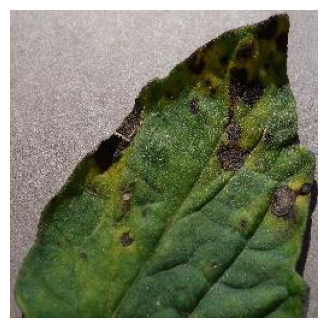

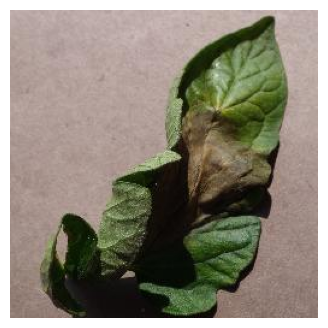

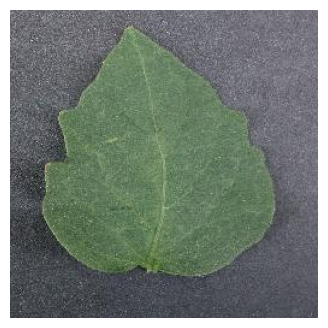

In [10]:
class_folders = {
    "Early_blight": "Tomato___Early_blight",
    "Late_blight": "Tomato___Late_blight",
    "Healthy": "Tomato___healthy"
}

for k, folder in class_folders.items():
    pattern = f"{data_root}/{folder}/*"
    files_list = sorted(glob(pattern))
    counts[k] = len(files_list)
    print(f"{k}: {counts[k]} images (example: {files_list[:3]})")
    if files_list:
        show_img(files_list[0], figsize=(4,4))

print("\nIf any count is 0, check the folder names or data_root above.")


**5-Convert classification images into a YOLO format detection dataset**

creates a YOLO style folders and labels using full image bounding boxes

In [11]:
os.makedirs("/content/yolo_dataset/images/train", exist_ok=True)
os.makedirs("/content/yolo_dataset/images/val", exist_ok=True)
os.makedirs("/content/yolo_dataset/labels/train", exist_ok=True)
os.makedirs("/content/yolo_dataset/labels/val", exist_ok=True)

class_map = {
    "Tomato___Early_blight": 0,
    "Tomato___Late_blight": 1,
    "Tomato___healthy": 2
}
all_images = []
for folder_name, cls_id in class_map.items():
    imgs = sorted(glob(f"{data_root}/{folder_name}/*.jpg")) + sorted(glob(f"{data_root}/{folder_name}/*.jpeg")) + sorted(glob(f"{data_root}/{folder_name}/*.png"))
    for p in imgs:
        all_images.append((p, cls_id))

print("Total images found:", len(all_images))
# shuffle for randomness
import random
random.shuffle(all_images)

# split
split_idx = int(0.85 * len(all_images))
train_list = all_images[:split_idx]
val_list = all_images[split_idx:]

def write_full_bbox(img_path, class_id, dst_img_path, dst_label_path):
    img = cv2.imread(img_path)
    if img is None:
        return False
    h, w = img.shape[:2]
    # YOLO full-image box centered
    x_center = 0.5
    y_center = 0.5
    box_w = 1.0
    box_h = 1.0
    # save image
    cv2.imwrite(dst_img_path, img)
    # write label
    with open(dst_label_path, 'w') as f:
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {box_w:.6f} {box_h:.6f}\n")
    return True

# Write train
for src, cid in tqdm(train_list, desc='writing train'):
    fn = Path(src).name
    write_full_bbox(src, cid, f"/content/yolo_dataset/images/train/{fn}", f"/content/yolo_dataset/labels/train/{Path(fn).stem}.txt")

# Write val
for src, cid in tqdm(val_list, desc='writing val'):
    fn = Path(src).name
    write_full_bbox(src, cid, f"/content/yolo_dataset/images/val/{fn}", f"/content/yolo_dataset/labels/val/{Path(fn).stem}.txt")

print("YOLO dataset created at /content/yolo_dataset")


Total images found: 171


writing val: 100%|██████████| 26/26 [00:00<00:00, 973.46it/s]

YOLO dataset created at /content/yolo_dataset


**6-Creating data.yaml**

YOLO needs data.yaml to know where the train-val images are and class names.

In [12]:
data_yaml = f"""
train: /content/yolo_dataset/images/train
val: /content/yolo_dataset/images/val

names:
  0: Early_blight
  1: Late_blight
  2: Healthy
"""
with open("data.yaml", "w") as f:
    f.write(data_yaml)
print("Wrote data.yaml:\n")
print(data_yaml)


Wrote data.yaml:


train: /content/yolo_dataset/images/train
val: /content/yolo_dataset/images/val

names:
  0: Early_blight
  1: Late_blight
  2: Healthy



**7-Visual check of labels**

To verify labels were created and visually inspect the images used for training.

Image: /content/yolo_dataset/images/train/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.jpeg
Label exists: True
Label content: 2 0.500000 0.500000 1.000000 1.000000
Image: /content/yolo_dataset/images/train/0003faa8-4b27-4c65-bf42-6d9e352ca1a5___RS_Late.B 4946.jpeg
Label exists: True
Label content: 1 0.500000 0.500000 1.000000 1.000000
Image: /content/yolo_dataset/images/train/000bf685-b305-408b-91f4-37030f8e62db___GH_HL Leaf 308.1.jpeg
Label exists: True
Label content: 2 0.500000 0.500000 1.000000 1.000000
Image: /content/yolo_dataset/images/train/0012b9d2-2130-4a06-a834-b1f3af34f57e___RS_Erly.B 8389.jpeg
Label exists: True
Label content: 0 0.500000 0.500000 1.000000 1.000000
Image: /content/yolo_dataset/images/train/0031da2a-8edd-468f-a8b1-106657717a32___RS_HL 0105.jpeg
Label exists: True
Label content: 2 0.500000 0.500000 1.000000 1.000000
Image: /content/yolo_dataset/images/train/00355ec2-f12c-4015-b8f9-94354f69ce22___RS_Late.B 5311.jpeg
Label exists: True
Label content: 

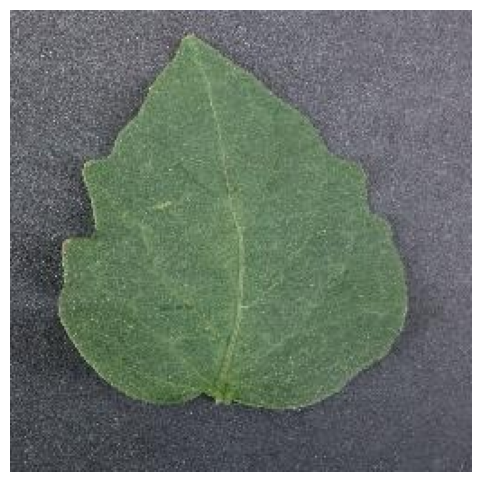

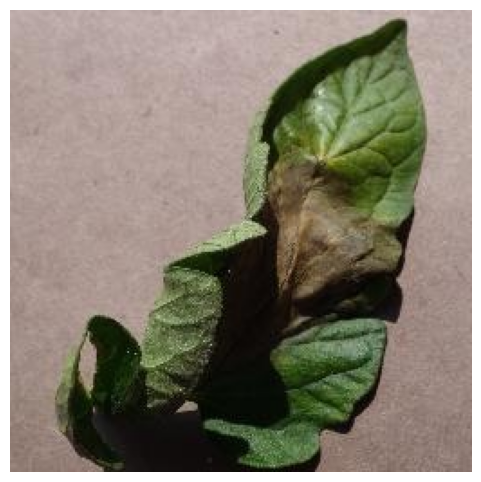

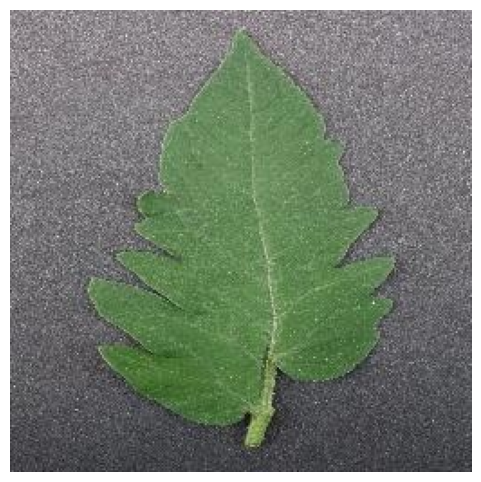

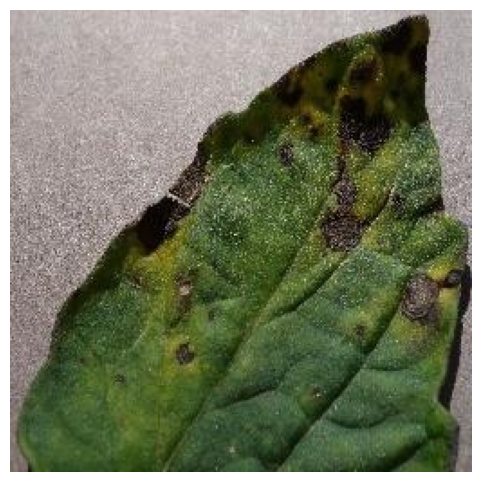

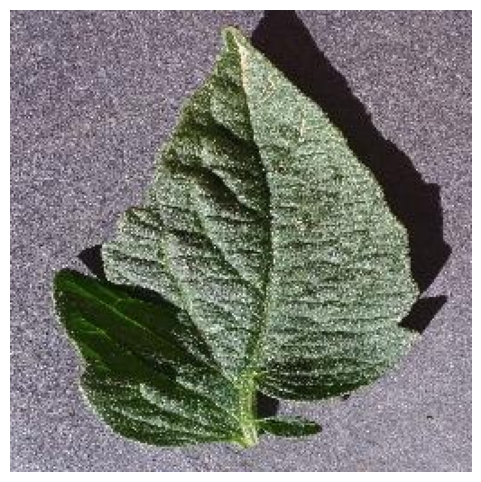

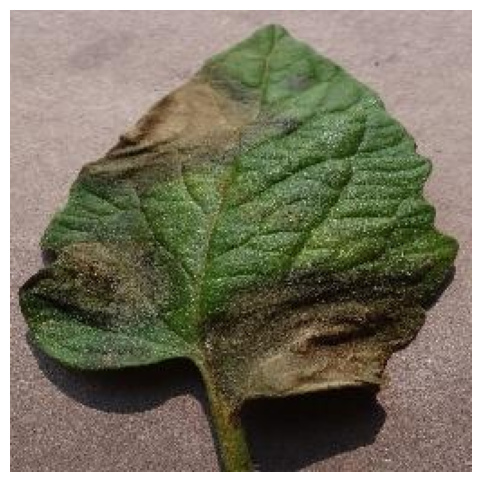

In [13]:
sample_train = sorted(glob('/content/yolo_dataset/images/train/*'))[:6]
for p in sample_train:
    print("Image:", p)
    lbl = f"/content/yolo_dataset/labels/train/{Path(p).stem}.txt"
    print("Label exists:", Path(lbl).exists())
    if Path(lbl).exists():
        print("Label content:", open(lbl).read().strip())
    show_img(p)


In [14]:
MODEL_BACKBONE = "yolov8s.pt"
model = YOLO(MODEL_BACKBONE)
print("Loaded model backbone:", MODEL_BACKBONE)


Loaded model backbone: yolov8s.pt


**8-Training the model with augmentations + sensible defaults**



In [15]:
model.train(
    data="data.yaml",
    epochs=30,
    imgsz=640,
    batch=16,
    name="tomato_detector_final",
    augment=True
)


Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=tomato_detector_final, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dcf5066e600>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

**Show training results**

In [16]:
from glob import glob
runs = sorted(glob('runs/detect/*'), key=os.path.getmtime)
print("Runs found:", runs[-1] if runs else "No runs found")
best_weights = Path(runs[-1]) / 'weights' / 'best.pt' if runs else None
print("Best weights path:", best_weights)


Runs found: runs/detect/tomato_detector_final
Best weights path: runs/detect/tomato_detector_final/weights/best.pt


**runs YOLO's built-in validation and prints the important metrics**

In [17]:
if best_weights and best_weights.exists():
    detector = YOLO(str(best_weights))
    print("Loaded trained weights:", best_weights)
    res = detector.val()
    print("Validation finished. Key metrics (res):", type(res))
else:
    print("Best weights not found. Can't run val()")


Loaded trained weights: runs/detect/tomato_detector_final/weights/best.pt
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1179.6±361.2 MB/s, size: 34.6 KB)
val: Scanning /content/yolo_dataset/labels/val.cache... 26 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 26/26 32.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.3it/s 0.9s
                   all         26         26      0.943          1      0.995      0.995
          Early_blight          6          6      0.995          1      0.995      0.995
           Late_blight         12         12      0.882          1      0.995      0.995
               Healthy          8          8      0.952          1      0.995      0.995
Speed: 5.6ms preprocess, 15.8ms inference, 0.0ms loss, 1.4ms pos

**sample predictions**


image 1/1 /content/yolo_dataset/images/val/00ce4c63-9913-4b16-898c-29f99acf0dc3___RS_Late.B 4982.jpeg: 640x640 1 Late_blight, 16.4ms
Speed: 5.2ms preprocess, 16.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/yolo_dataset/images/val/0334d40b-d880-442f-a7db-e5c85a2e0bed___RS_Late.B 6367.jpeg: 640x640 1 Late_blight, 16.3ms
Speed: 1.9ms preprocess, 16.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/yolo_dataset/images/val/03ccfc6a-8142-4f46-8eb5-f7fc77978081___RS_Late.B 4916.jpeg: 640x640 1 Late_blight, 16.2ms
Speed: 2.0ms preprocess, 16.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


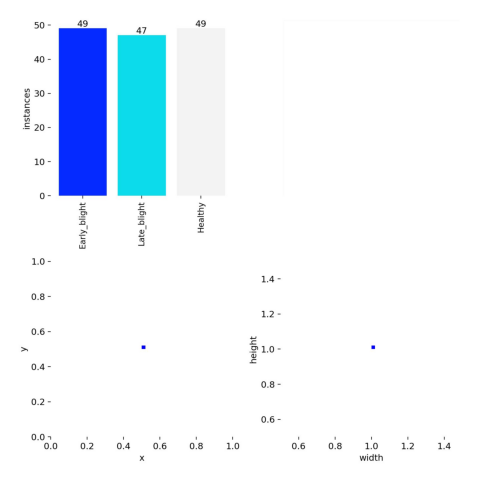

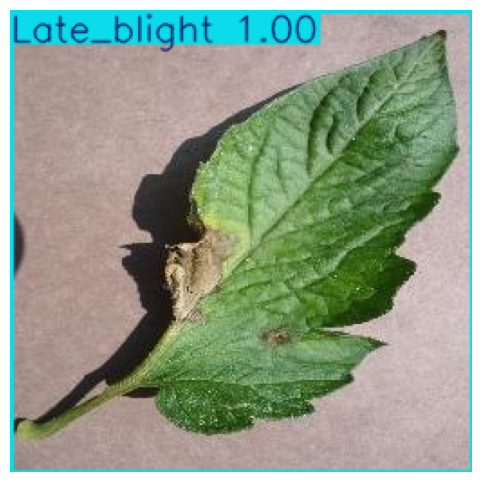

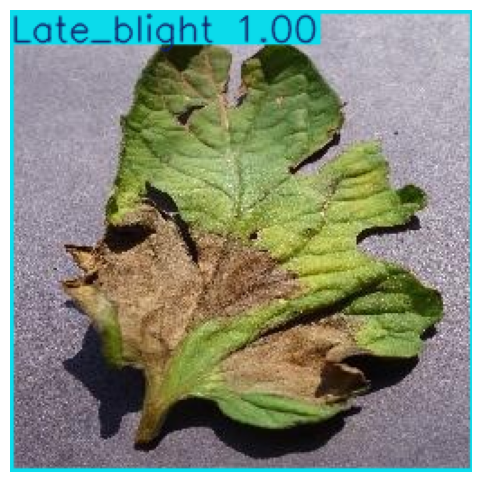

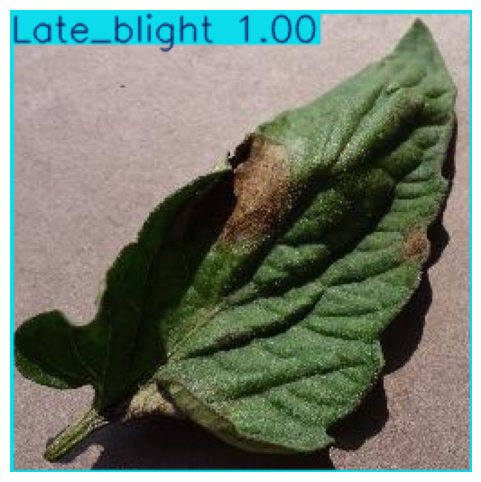

In [26]:
# The training run usually stores a labels.jpg and other plots in the run folder
plots_dir = Path(runs[-1]) / 'plots' if runs else None
labels_img = Path(runs[-1]) / 'labels.jpg' if runs else None

if labels_img and labels_img.exists():
    show_img(str(labels_img), figsize=(8,6))
else:
    print("No labels.jpg plot found. Showing some validation predictions instead.")

# show 3 sample validation predictions (if detector available)
val_imgs = sorted(glob('/content/yolo_dataset/images/val/*'))[:6]
if 'detector' in globals():
    for p in val_imgs[:3]:
        r = detector(p)[0]
        ann = r.plot()
        # Directly display the annotated image (NumPy array) using matplotlib
        plt.figure(figsize=(6,6)); plt.axis('off'); plt.imshow(cv2.cvtColor(ann, cv2.COLOR_BGR2RGB))

**Treatment tips and a convenient inference function**

maps that predicted class names to treatment tips and defines

In [30]:
TREATMENT_TIPS = {
    "Early_blight": "Remove infected leaves and apply a copper-based fungicide.",
    "Late_blight": "Improve airflow and use chlorothalonil; remove badly infected plants.",
    "Healthy": "Leaf appears healthy — no action required."
}

def predict_and_tip(img_path, model=detector):
    r = model(img_path)[0]
    if len(r.boxes) == 0:
        print("No detections.")
        show_img(img_path)
        return
    for b in r.boxes:
        cls_id = int(b.cls[0]); conf = float(b.conf[0])
        name = model.names[cls_id]
        tip = TREATMENT_TIPS.get(name, "No tip available.")
        print(f"Detected: {name} (conf={conf:.2f})")
        print("Tip:", tip)
    ann = r.plot()
    # Directly display the annotated image (NumPy array) using matplotlib
    plt.figure(figsize=(6,6)); plt.axis('off'); plt.imshow(cv2.cvtColor(ann, cv2.COLOR_BGR2RGB))

**Testing images**

Upload images (tomato leaves) to run inference on trained model


Saving download (2).jpeg to download (2).jpeg

=== Running prediction on: download (2).jpeg

image 1/1 /content/download (2).jpeg: 640x480 1 Late_blight, 46.0ms
Speed: 2.5ms preprocess, 46.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)
Detected: Late_blight (conf=0.99)
Tip: Improve airflow and use chlorothalonil; remove badly infected plants.


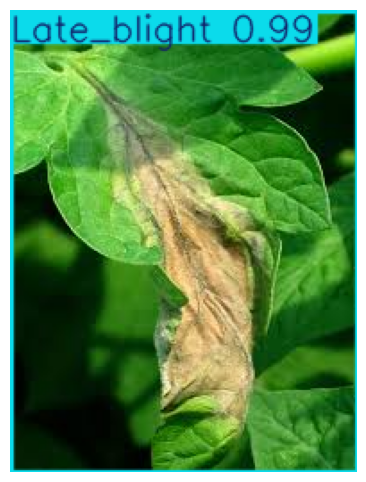

In [36]:
print("Upload images (tomato leaves) to run inference on trained model")
uploaded = files.upload()
for fn in uploaded.keys():
    print("\n=== Running prediction on:", fn)
    predict_and_tip(fn)
